In [2]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
%matplotlib inline

# profile

## line plot (use center)

In [ ]:
##### !!! better to use the function in the next part to get the signal

bw_scan = True

import subprocess

# name = 'HisMod_around_CTKI_peakSummit'
# capture_regions_file = '../CTKI_nanog_dome_final_summits.bed'
name = 'HisMod_around_CTKI_targetsTSS'
capture_regions_file = '../targets/CTKI_targets_TSS.bed'
resolution = 100
span = 2000
capture_points = int(2 * span / resolution + 1)
xticks = np.arange(-span, span + resolution, resolution)
bigwig_files = [
    '../../../ChIPseq/2_signal/ChIPseq_H3K27me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K36me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K4me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K27ac_dome_rep3.bw',
    '../../../ChIPseq/2_signal/ChIPseq_Pol2_dome_4H8.bw',
]
labels = [
    'H3K27me3',
    'H3K36me3',
    'H3K4me3',
    'H3K27ac',
    'Pol2',
]

cmd = f'''awk '{{print $1"\\t"$2-{span}-{resolution >> 1}"\\t"$3+{span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
print(subprocess.check_output(cmd, shell=True).decode(), end='')

capture_regions_file = 'capture_regions.bed'
# bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'
bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file} --strand'

for bigwig_file in bigwig_files:
    bw_scan_cmd += f' -w {bigwig_file}'

if bw_scan:
    print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')


def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


signal['CTKI'] = {}
for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
    mean = get_bigwig_mean(bigwig_file)
    signal['CTKI'][label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                sep='\t',
                                header=None,
                                index_col=None,
                                names=xticks) / mean
signal['CTKI'][labels[0]].head()

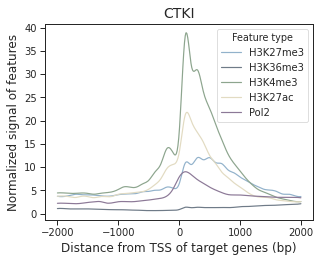

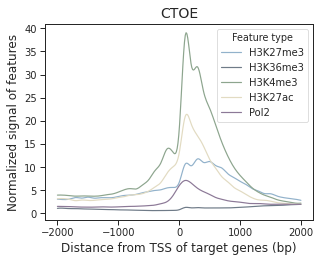

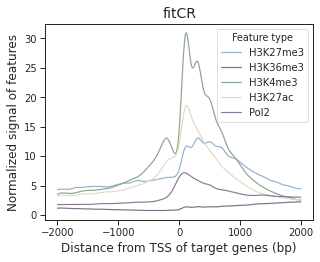

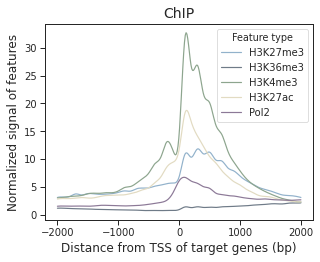

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    colors = ['#92B2CB', '#6F7B88', '#8DA58E', '#E2DBC2', '#8C7997']
    for K in signal.keys() :
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75))
        i = 0
        for label in ['H3K27me3','H3K36me3','H3K4me3','H3K27ac','Pol2']:
            x = signal[K][labels[0]].columns
            xnew = np.linspace(x.min(), x.max(), 300) 
            spl = make_interp_spline(x, signal[K][label].mean(), k = 3)
            signal_smooth = spl(xnew)
            ax.plot(xnew, signal_smooth, label=label, color=colors[i])
            i += 1
            
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ['H3K27me3','H3K36me3','H3K4me3','H3K27ac','Pol2'], title="Feature type")
        
        ax.set_xlabel('Distance from TSS of target genes (bp)')
        ax.set_ylabel('Normalized signal of features')
        ax.set_title(K)
#         fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_line_HisModCov_{K}.pdf', transparent=True)
        fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_line_HisModCov_{K}_targetTSS.pdf', transparent=True)        

## line plot (used scaled region with flankings)

In [ ]:
def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def scan_bw_signal_split2bins(bw_scan, name, capture_regions_file, bigwig_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'

    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                    sep='\t',
                                    header=None,
                                    index_col=None,
                                    names=xticks) / mean     
    return signal

In [ ]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [ ]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/')
signal_AB_dict = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'intersectOnly_UniversalCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'intersectOnly_UniversalCHM_5tissue_{compart}.bed'
        bw_scan = True if end != '5end' else True
#             resolution = 100 if end == 'body' else 500
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict[end][compart] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_CHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [ ]:
signal_AB_concat_dict = {}
# for span in [5000, 10000, 50000, 100000, 500000, 1000000, 2000000] :
for span in [50000, 100000] :
    signal_AB_concat_dict[span] = {}
    for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :        
        signal_AB_concat_dict[span][label] = {}
        for compart in ['A', 'B'] :
            signal_AB_concat_dict[span][label][compart] = pd.concat([signal_AB_dict['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                                signal_AB_dict['body'][compart][label], 
                                                                                signal_AB_dict['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
            body_len = signal_AB_dict['body'][compart][label].columns[-1] - signal_AB_dict['body'][compart][label].columns[0]
            signal_AB_concat_dict[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
    
signal_AB_concat_dict[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,1.222536,0.660323,0.776326,0.891054,0.763578,0.758479,0.643751,1.129433,1.483925,1.281148,...,2.372451,2.389028,2.071611,1.942864,1.851073,1.649670,1.801368,2.032097,1.559165,1.524779
1,2.095834,1.988752,1.568070,1.411269,1.666234,1.718509,1.540030,1.687913,2.062693,2.522877,...,1.436764,1.472463,1.709578,2.224582,2.767625,2.276844,2.349513,3.559272,3.315770,3.652776
2,2.111126,1.532358,1.309234,1.392121,1.654772,1.946680,1.487768,1.089921,1.356409,1.803913,...,0.987935,0.446164,0.316139,0.610608,0.883405,0.699841,0.309766,0.430867,0.610608,0.773688
3,0.000000,0.000000,0.026770,0.193763,0.495880,1.115419,1.693014,2.327834,2.564936,1.947965,...,0.647576,1.255673,2.125146,2.139179,1.460974,1.245472,1.527283,1.557880,1.811558,1.806243
4,1.004507,0.843888,0.952242,0.860460,1.019819,1.838326,1.616502,0.945868,1.574417,1.965801,...,1.692961,1.551506,2.250077,2.287048,2.176136,2.098378,2.211834,1.805185,1.394679,1.413693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,0.006374,0.247303,0.571090,1.188119,1.325812,0.823492,0.518825,0.271523,0.724061,1.186797,...,2.380097,2.999638,2.805868,2.174864,1.741447,2.004044,1.913539,2.241159,3.124556,2.634204
942,0.000000,0.000000,0.067562,0.360756,0.537947,0.404097,0.159344,0.014022,0.558343,0.980287,...,0.000000,0.349283,0.518825,0.342909,0.750831,1.069520,0.792898,0.718962,0.693467,0.705533
943,0.863009,0.678170,0.808195,0.416845,0.508627,0.739358,0.625905,0.539221,0.769952,0.740633,...,1.670023,1.760568,2.122601,2.302339,2.204188,1.555309,1.351308,0.975188,0.604234,0.697961
944,1.040200,1.292650,1.371728,1.707034,1.524712,1.200874,1.313041,1.884228,1.977277,1.274794,...,0.580014,0.744457,0.500979,0.605509,1.255677,1.241620,0.820942,0.815843,0.972638,1.312659


In [ ]:
colors = ['#C490C6', '#90ADC6']

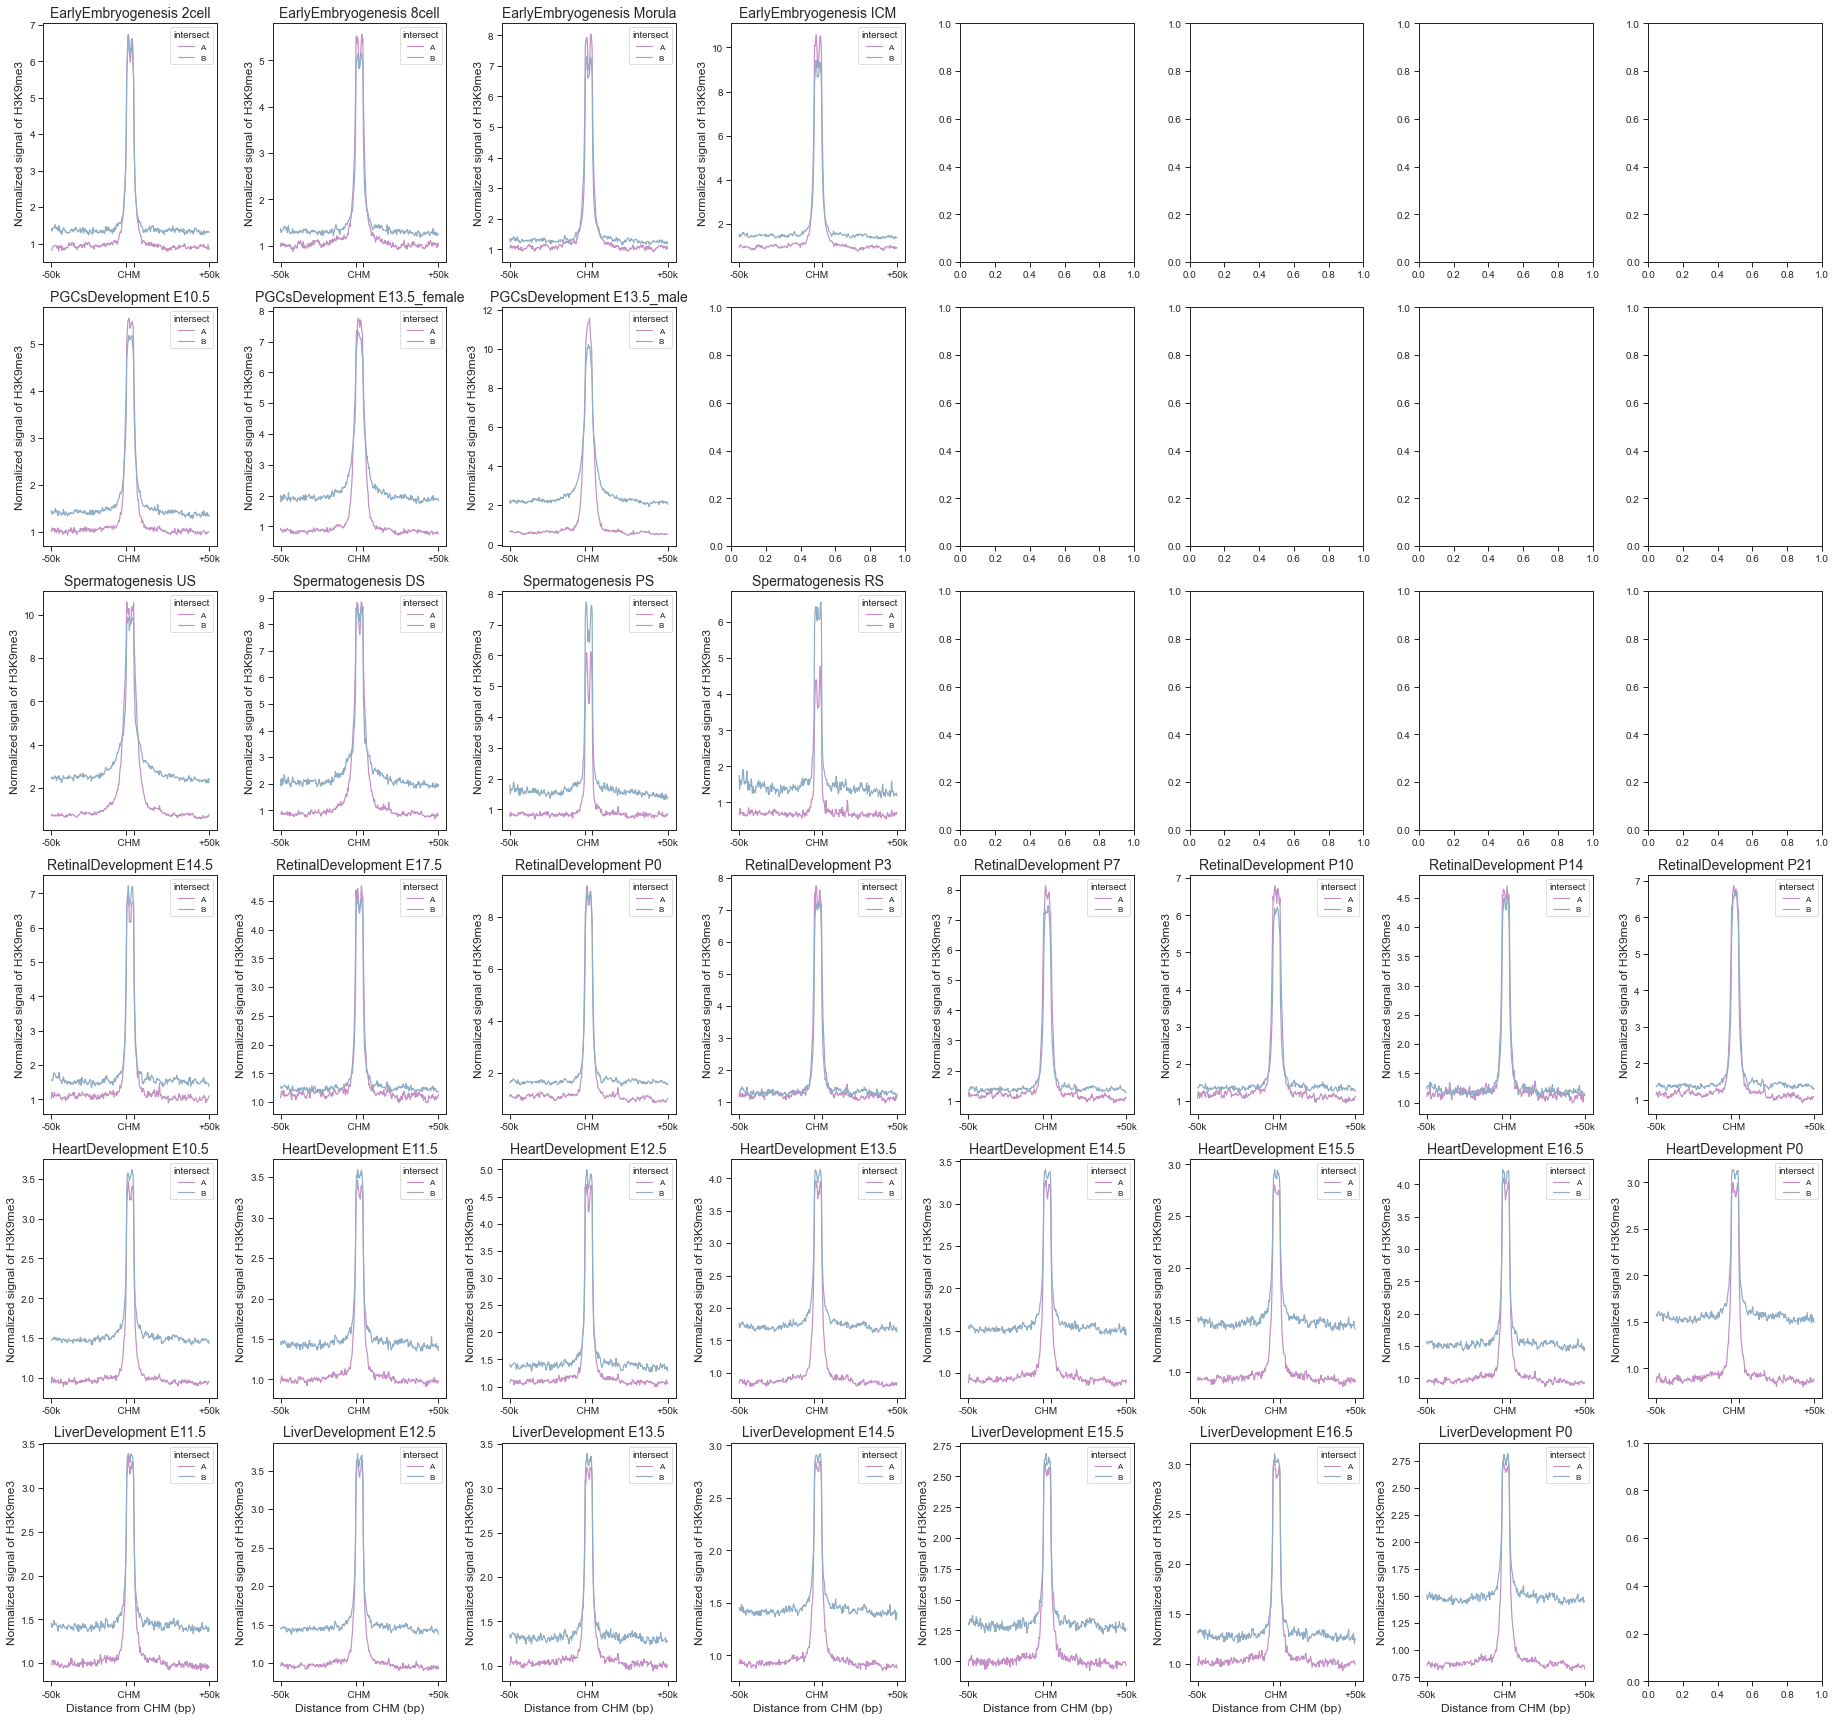

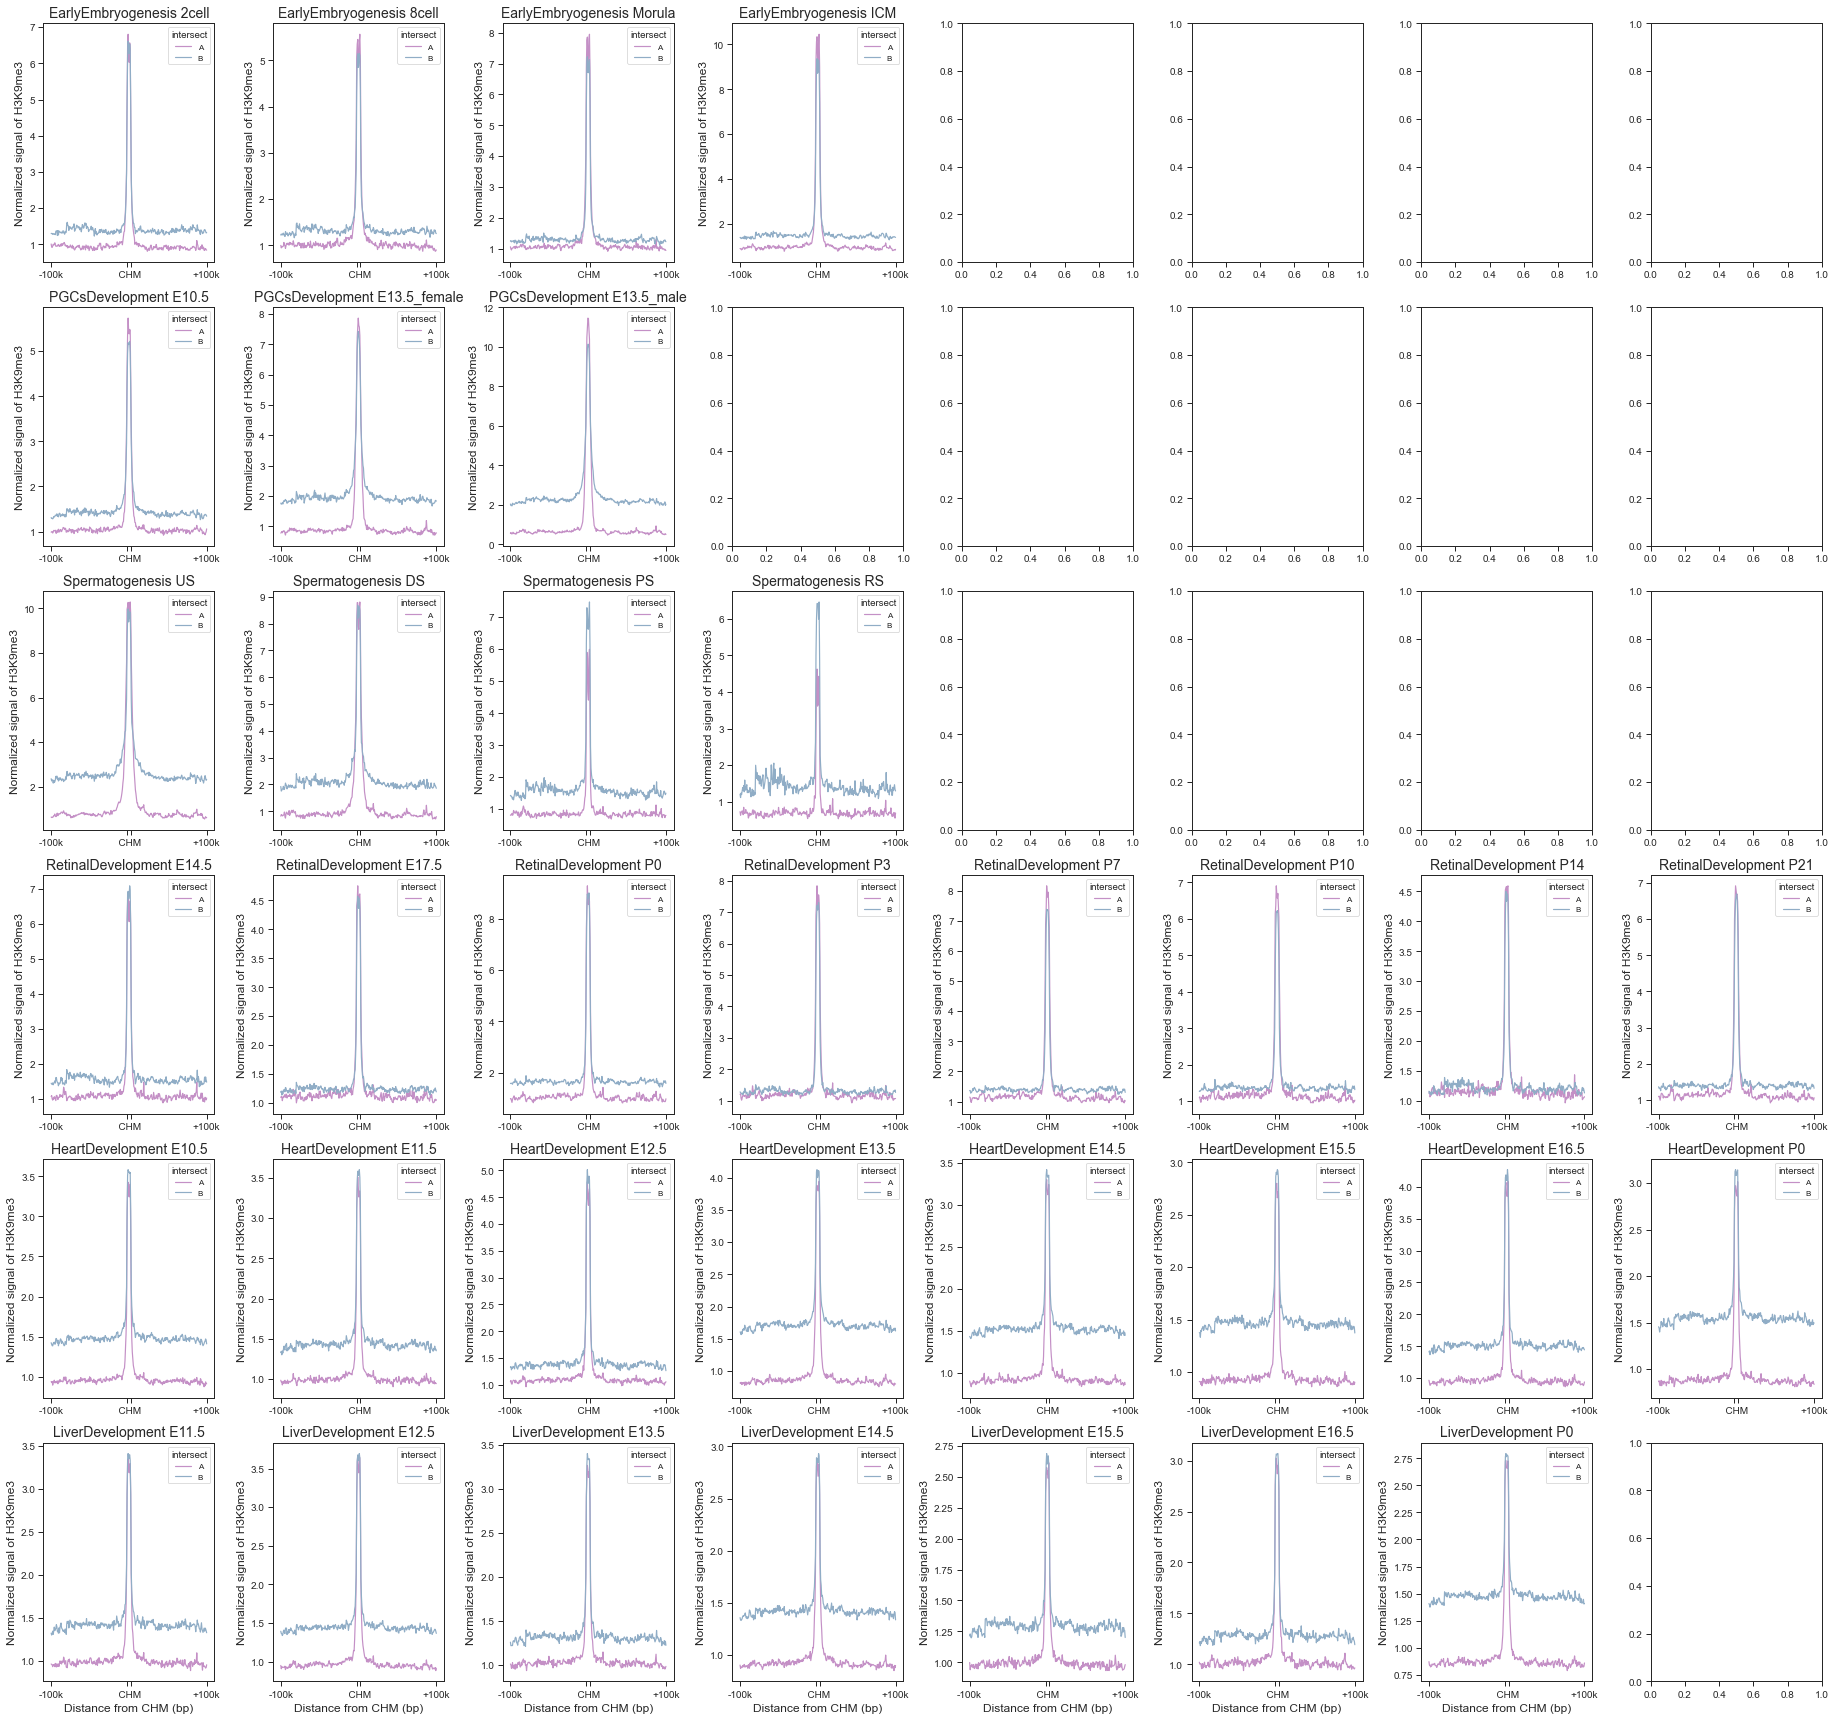

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
#     for span in [10000, 50000, 100000, 500000, 1000000, 2000000] :    
    for span in [50000, 100000] :    
#         for cell_type in ['ES', 'NPC', 'CN'] :
        for cell_type in ['intersect'] :
            fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = False, tight_layout = True)  
    #         fig.tight_layout(rect=[0, 0.025, 1, .97])
    #         fig.suptitle(f'A/B compartment data from {cell_type}', size = 15)
    #         for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :
            for a,process in enumerate(stage_dict.keys()) :
                for b,stage in enumerate(stage_dict[process]) : 
    #                 ax = axes[int(i/6), i%6]
                    ax = axes[a, b]
                    label = f'{process}_{stage}_H3K9me3'
#                     for j,compart in enumerate(['totallyInside_A', 'totallyInside_B']) :
                    for j,compart in enumerate(['overlap_A', 'overlap_B']) :
                        x = signal_AB_concat_dict[span][cell_type][label][compart].columns
                        xnew = np.linspace(x.min(), x.max(), 300) 
                        spl = make_interp_spline(x, signal_AB_concat_dict[span][cell_type][label][compart].mean(), k = 3)
                        signal_smooth = spl(xnew)
        #                 ax.plot(xnew, signal_smooth, label=compart, color=color_dict[label.split('_')[0]][j])
                        ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

#                     if b == (len(stage_dict[process])-1) :
                    h, l = ax.get_legend_handles_labels()
                    ax.legend(h, ['A', 'B'], title=cell_type)

                    ax.set_xticks([-span, 0, 5000, 5000+span])
#                     ax.set_xticklabels([f'-{str(span)[:-3]}k', f'-{str(int(span/2))[:-3]}k', " CHM", "", f"+{str(int(span/2))[:-3]}k", f"+{str(span)[:-3]}k"])
                    ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                    if a == (len(stage_dict.keys()) - 1) :
                        ax.set_xlabel('Distance from CHM (bp)')
                    ax.set_ylabel('Normalized signal of H3K9me3')
                    ax.set_title(f'{process} {stage}')

            fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_UniversalCHM_overlap_ABcompart_{cell_type}_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        


## heatmap

In [ ]:
peak_num_dict = {
   'CR_nanogKI_dome_20230228' : 7683 ,
'CR_sox19bKI_oocyte_20230301' : 286   ,
 'CR_nanogKI_oocyte_20230320' : 258   ,
}

In [ ]:
import subprocess

def get_bigwig_mean(bw_file):
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def scan_bw_signal_split2bins(bw_scan, name, capture_regions_file, bigwig_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'

    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                    sep='\t',
                                    header=None,
                                    index_col=None,
                                    names=xticks) / mean     
    return signal

In [ ]:
os.chdir('/mnt/Storage/home/wangyiman/knock_in_Sun/analysis/signal_cov')
signal_dict = {}
for sample in ['CR_nanogKI_dome_20230228',  
             'CR_sox19bKI_oocyte_20230301', 
             'CR_nanogKI_oocyte_20230320', ] :
    bed_fi = f'../../3_peak/{sample}_filtered_summits.bed'
    bw_scan = True 
    resolution = 50
    left_span = 1000
    right_span = 1000
    origin_len = 1
    signal_dict[sample] = scan_bw_signal_split2bins(
        bw_scan = bw_scan,
        name = f'signal_around_{sample}_peak_summits',
        capture_regions_file = bed_fi,
        resolution = resolution,
        left_span = left_span,
        right_span = right_span,
        origin_len = origin_len,
        bigwig_files = [f'/mnt/Storage/home/wangyiman/knock_in_Sun/2_signal/{sample}.bw'],
        labels = [f'{sample}'],
    )

In [ ]:
signal_dict['CR_nanogKI_dome_20230228']['CR_nanogKI_dome_20230228']

,-1000,-950,-900,-850,-800,-750,-700,-650,-600,-550,...,550,600,650,700,750,800,850,900,950,1000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,2.681516,2.681516,5.363025,8.044534,5.363025,2.681516,5.363025,5.363032,5.363025,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,2.681516,2.681516,0.000000,0.000000,0.000000,0.000000,2.681516,2.681516,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,2.681516,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,2.681516,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,8.044534,12.066801,9.385312,13.407579,2.681516,0.000000,2.681516,2.681516,5.257867
4,2.681516,0.000000,0.000000,0.000000,0.000000,0.0,2.681516,2.681516,0.000000,0.0,...,2.681516,0.000000,5.363025,2.681516,0.000000,0.000000,0.000000,0.000000,10.726023,5.257867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7678,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,2.681516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7679,0.000000,5.363025,2.681516,0.000000,0.000000,0.0,0.000000,2.681516,2.681516,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.363025,10.726023,10.726023,5.363025,5.257867
7680,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.681516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7681,0.000000,0.000000,0.000000,0.000000,5.363025,0.0,0.000000,8.044534,2.681516,0.0,...,0.000000,2.681516,0.000000,5.363025,5.363025,10.726023,0.000000,0.000000,2.681516,0.000000


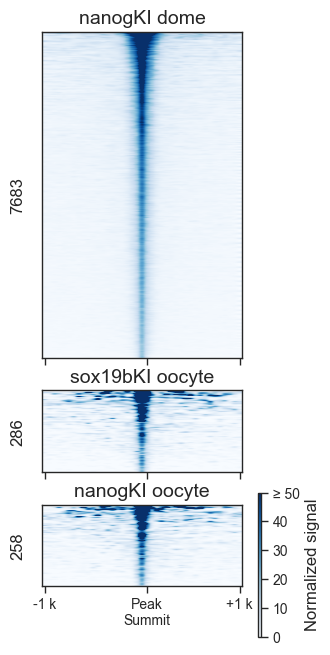

In [ ]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):

    fig, axes = plt.subplots(3,1, 
                            gridspec_kw={
                            'height_ratios': [4,1,1]
                            }, 
                            figsize=[6.4 * .5, 4.8 * 1.5], 
                            #  sharey = 'row', 
                            sharex = 'col',
                            # tight_layout=True
                                )   
    for i,K in enumerate(['CR_nanogKI_dome_20230228',  
              'CR_sox19bKI_oocyte_20230301', 
              'CR_nanogKI_oocyte_20230320', ]) :
     
        df = signal_dict[K][K].assign(m=signal_dict[K][K].mean(axis=1)).sort_values('m', ascending=False).drop('m', axis=1)
        pos = axes[i].imshow(df, cmap='Blues', aspect='auto', vmax=50, vmin=0, interpolation='gaussian')
        axes[i].yaxis.set_ticks_position('none') 
        axes[i].set_yticklabels([])
        axes[i].set_xticks([0,21,40])
        axes[i].set_xticklabels(['-1 k', 'Peak\nSummit', '+1 k'])
        title = K.split('_')[1] + ' ' + K.split('_')[2]
        axes[i].set_title(title)
        axes[i].set_ylabel(peak_num_dict[K])
        
    fig.subplots_adjust(right=0.75)
    cbar_ax = fig.add_axes([0.8, 0.04, 0.01, 0.2])
    cbar = fig.colorbar(pos, cax=cbar_ax, extend='neither', ticks=[0, 10, 20, 30, 40, 50])
    cbar.set_label('Normalized signal')
    cbar.ax.set_yticklabels(['0', '10', '20', '30', '40','≥ 50']) 

    
    fig.savefig('/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make15_heatmap_signal_around_peak_202303.pdf', transparent=True)


# mean

In [ ]:
bw_scan = False

import subprocess

name = 'atac_OCR_specific'
capture_regions_file = 'atac_validation/atac_wt_OCR_specific_peaks_Pou5f3.narrowPeak'
resolution = 100
span = 2000
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_pou5f3_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]

cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_atac_OCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_atac_OCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_atac_OCR_specific

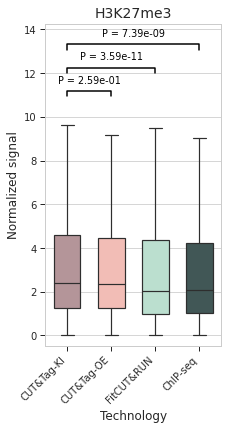

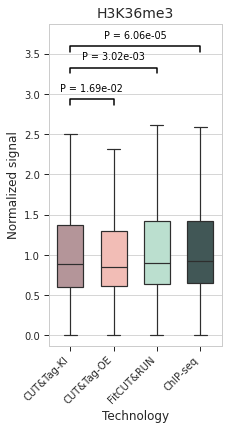

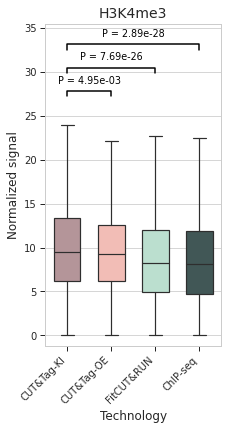

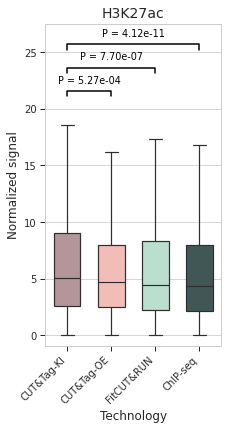

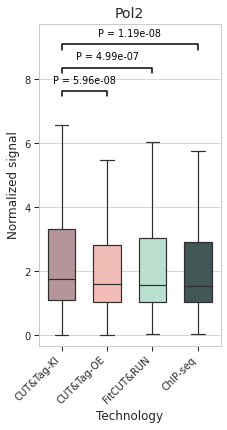

In [ ]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    for feature in signal_mean['CTKI'].columns :
        signals = signal_mean['CTKI'][feature].tolist() + signal_mean['CTOE'][feature].tolist() + signal_mean['fitCR'][feature].tolist() + signal_mean['ChIP'][feature].tolist()
        techs = ['CUT&Tag-KI'] * signal_mean['CTKI'].shape[0] + ['CUT&Tag-OE'] * signal_mean['CTOE'].shape[0] + ['FitCUT&RUN'] * signal_mean['fitCR'].shape[0] + ['ChIP-seq'] * signal_mean['ChIP'].shape[0]
        plot_pd = pd.DataFrame({'signals' : signals, 'Technology' : techs})
        fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * 1.25))
        boxplot(
            x='Technology',
            y='signals',
            data=plot_pd,
            palette=['#B99095','#FCB5AC','#B5E5CF', "#3D5B59"],
            showfliers=False,
            statistic_args={'statistic_test': 'mannwhitneyu',
                            'use_continuity': False,},
            ax=ax,
            centerCol = 0,
            width = .6
        )
        ax.set_ylabel('Normalized signal')
        ax.set_xticklabels(labels=ax.get_xticklabels(),
                           rotation=45, ha='right')
        ax.set_ylim(top = 1.25 * ax.get_ylim()[1])
        ax.set_title(feature)
        fig.tight_layout()
        fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_boxplot_{feature}_ov_techs_mean.pdf',
                    transparent=True)